In [1]:
from xbbg import blp
from blp import blp as bp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime, timedelta, time
from zoneinfo import ZoneInfo
from matplotlib.patches import Patch


In [2]:
from datetime import datetime, time
from zoneinfo import ZoneInfo

# Geneva timezone (handles CEST/CET automatically)
geneva_tz = ZoneInfo("Europe/Zurich")

# Get current time in Geneva
now_geneva = datetime.now(geneva_tz)

# Set 2:00 AM today in Geneva
start_geneva = now_geneva.replace(hour=2, minute=0, second=0, microsecond=0)

#start_geneva = now_geneva - timedelta(hours=72) # use this for showing the last 3 days

# Convert both to UTC
start_datetime = start_geneva.astimezone(ZoneInfo("UTC")).strftime('%Y-%m-%dT%H:%M:%S')
end_datetime = now_geneva.astimezone(ZoneInfo("UTC")).strftime('%Y-%m-%dT%H:%M:%S')

#Get intraday data for both instruments
def get_intraday_data(ticker, start_dt, end_dt):
    bquery = bp.BlpQuery().start()
    return bquery.bdib(
        ticker,
        event_type="ASK",
        interval=5,
        start_datetime=start_dt,
        end_datetime=end_dt,
    )
    

In [3]:
def classify_regime(df, lookback=6):
    df = df.copy()
    df['chg_2y'] = df['close_2y'].diff(lookback)
    df['chg_10y'] = df['close_10y'].diff(lookback)

    conditions = [
        (df['chg_2y'] < 0) & (df['chg_10y'] <= 0) & (df['chg_10y'] > df['chg_2y']),
        (df['chg_2y'] >= 0) & (df['chg_10y'] > 0) & (df['chg_10y'] > df['chg_2y']),
        (df['chg_2y'] <= 0) & (df['chg_10y'] < 0) & (df['chg_10y'] < df['chg_2y']),
        (df['chg_2y'] > 0) & (df['chg_10y'] >= 0) & (df['chg_10y'] < df['chg_2y']),
        (df['chg_2y'] > 0) & (df['chg_10y'] < 0),
        (df['chg_2y'] < 0) & (df['chg_10y'] > 0)
    ]

    labels = ['BullSteepener', 'BearSteepener', 'BullFlattener',
              'BearFlattener', 'TwistFlattener', 'TwistSteepener']

    df['regime'] = np.select(conditions, labels, default='Other')
    return df


In [4]:

def plot_yield_curve_regimes(df):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    from matplotlib.patches import Patch

    df = df.copy()
    df['2s10s'] = df['close_10y'] - df['close_2y']
    df = df.dropna(subset=['2s10s'])  # Ensure no NaNs in spread

    fig, ax = plt.subplots(figsize=(18, 6))

    # Plot the 2s10s curve
    ax.plot(df.index, df['2s10s'], color='white', linewidth=2, label='2s10s')

    # Color map for regimes
    regime_colors = {
        'BullSteepener': 'green',
        'BearSteepener': 'red',
        'BullFlattener': 'deepskyblue',
        'BearFlattener': 'orange',
        'TwistFlattener': 'violet',
        'TwistSteepener': 'gold',
        'Other': 'grey'
    }

    # Get y-axis limits
    ymin = df['2s10s'].min() - 0.01
    ymax = df['2s10s'].max() + 0.01

    # Fill regime colors
    for i in range(1, len(df)):
        t_curr = df.index[i]
        t_prev = df.index[i - 1]
        regime = df['regime'].iloc[i]
        color = regime_colors.get(regime, 'grey')

        ax.fill_between([t_prev, t_curr],
                        [ymin, ymin],
                        [df['2s10s'].iloc[i], df['2s10s'].iloc[i]],
                        color=color,
                        alpha=0.5)

    #  Add vertical day separators
    dates = pd.to_datetime(df.index.date).unique()
    for day in dates:
        intraday_start = pd.Timestamp(day) + pd.Timedelta(hours=6)
        ax.axvline(intraday_start, color='white', linestyle='--', linewidth=0.7, alpha=0.5)

    # 🎨 Add custom legend for regime colors
    regime_patches = [Patch(facecolor=color, edgecolor='none', label=label)
                      for label, color in regime_colors.items()]
    line_legend = ax.plot([], [], color='white', linewidth=2, label='2s10s')[0]  # dummy line

    # Add both the line and regime legend
    ax.legend(handles=[line_legend] + regime_patches, loc='upper left', fontsize=8)

    # Plot styling
    ax.set_ylim(ymin, ymax)
    ax.set_title('2s10s Yield Curve (30-min lookback)', color='white', fontsize=14)
    ax.set_facecolor('black')
    fig.patch.set_facecolor('black')
    ax.tick_params(colors='white')
    ax.grid(False)

    plt.show()

In [5]:
"""
def plot_yield_curve_regimes(df):
    import pandas as pd
    import numpy as np
    from zoneinfo import ZoneInfo
    import plotly.graph_objects as go

    df = df.copy()
    df['2s10s'] = df['close_10y'] - df['close_2y']
    df = df.dropna(subset=['2s10s'])

    # Colors
    regime_colors = {
        'BullSteepener': 'green',
        'BearSteepener': 'red',
        'BullFlattener': 'deepskyblue',
        'BearFlattener': 'orange',
        'TwistFlattener': 'violet',
        'TwistSteepener': 'gold',
        'Other': 'grey'
    }

    ymin = df['2s10s'].min() - 0.01
    ymax = df['2s10s'].max() + 0.01

    fig = go.Figure()

    # --- Regime-colored area under the curve (segment by segment) ---
    # Find contiguous segments where regime is constant
    regime = df['regime'].fillna('Other').to_numpy()
    x = df.index.to_numpy()
    y = df['2s10s'].to_numpy()

    # indices where regime changes (segment boundaries)
    boundaries = np.where(regime[1:] != regime[:-1])[0] + 1
    starts = np.r_[0, boundaries]
    ends = np.r_[boundaries, len(df)]

    for s, e in zip(starts, ends):
        seg_x = x[s:e]
        seg_y = y[s:e]
        seg_label = regime[s]
        seg_color = regime_colors.get(seg_label, 'grey')

        # 1) baseline trace (y=ymin) for this segment
        fig.add_trace(go.Scatter(
            x=seg_x, y=np.full_like(seg_y, ymin, dtype=float),
            mode='lines',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip'
        ))

        # 2) filled area from baseline up to the curve
        fig.add_trace(go.Scatter(
            x=seg_x, y=seg_y,
            mode='lines',
            line=dict(width=0),
            fill='tonexty',          # fill to the previous (baseline) trace
            fillcolor=seg_color,
            opacity=0.25,
            name=seg_label,
            legendgroup=seg_label,
            showlegend=False  # we’ll add a compact legend separately
        ))

    # --- Main 2s10s line on top ---
    fig.add_trace(go.Scatter(
        x=df.index, y=df['2s10s'],
        mode='lines',
        name='2s10s',
        line=dict(width=2, color='white')
    ))

    # --- Compact legend entries (one per regime) ---
    for label, color in regime_colors.items():
        fig.add_trace(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=10, color=color),
            name=label,
            showlegend=True
        ))

    # --- Geneva 06:00 separators ---
    geneva_tz = ZoneInfo("Europe/Zurich")
    idx_local = df.index.tz_convert(geneva_tz) if getattr(df.index, "tz", None) else df.index.tz_localize(geneva_tz)
    for day in pd.unique(idx_local.normalize()):
        intraday_start = (day + pd.Timedelta(hours=6))
        intraday_start_plot_tz = intraday_start.tz_convert(df.index.tz) if getattr(df.index, "tz", None) else intraday_start.tz_localize(None)
        fig.add_vline(x=intraday_start_plot_tz, line_dash='dash', opacity=0.5)

    # --- Layout ---
    fig.update_layout(
        title='2s10s Yield Curve (30-min lookback)',
        plot_bgcolor='black',
        paper_bgcolor='black',
        font=dict(color='white'),
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='left', x=10),
        margin=dict(l=50, r=20, t=60, b=40),
        hovermode='x unified'
    )
    fig.update_yaxes(range=[ymin, ymax], zeroline=False, showgrid=False, color='white')
    fig.update_xaxes(showgrid=False, color='white')

    # Use browser renderer to avoid nbformat dependency
    fig.show(renderer="browser")
"""

'\ndef plot_yield_curve_regimes(df):\n    import pandas as pd\n    import numpy as np\n    from zoneinfo import ZoneInfo\n    import plotly.graph_objects as go\n\n    df = df.copy()\n    df[\'2s10s\'] = df[\'close_10y\'] - df[\'close_2y\']\n    df = df.dropna(subset=[\'2s10s\'])\n\n    # Colors\n    regime_colors = {\n        \'BullSteepener\': \'green\',\n        \'BearSteepener\': \'red\',\n        \'BullFlattener\': \'deepskyblue\',\n        \'BearFlattener\': \'orange\',\n        \'TwistFlattener\': \'violet\',\n        \'TwistSteepener\': \'gold\',\n        \'Other\': \'grey\'\n    }\n\n    ymin = df[\'2s10s\'].min() - 0.01\n    ymax = df[\'2s10s\'].max() + 0.01\n\n    fig = go.Figure()\n\n    # --- Regime-colored area under the curve (segment by segment) ---\n    # Find contiguous segments where regime is constant\n    regime = df[\'regime\'].fillna(\'Other\').to_numpy()\n    x = df.index.to_numpy()\n    y = df[\'2s10s\'].to_numpy()\n\n    # indices where regime changes (segment 

In [6]:
#Pull intraday data
print("Fetching 2Y ESTR data...")
ESTR_2y = get_intraday_data("EESWE2 Curncy", start_datetime, end_datetime)
print("Fetching 10Y ESTR data...")
ESTR_10y = get_intraday_data("EESWE10 Curncy", start_datetime, end_datetime)

#Merge dataframes on time
ESTR_combined = pd.merge(ESTR_2y[['time', 'close']], ESTR_10y[['time', 'close']], 
                      on='time', suffixes=('_2y', '_10y'))

#Set time as index
ESTR_combined['time'] = pd.to_datetime(ESTR_combined['time'], utc=True)
ESTR_combined.set_index('time', inplace=True)
ESTR_combined.index = ESTR_combined.index.tz_convert('Europe/Zurich')


Fetching 2Y ESTR data...
Fetching 10Y ESTR data...


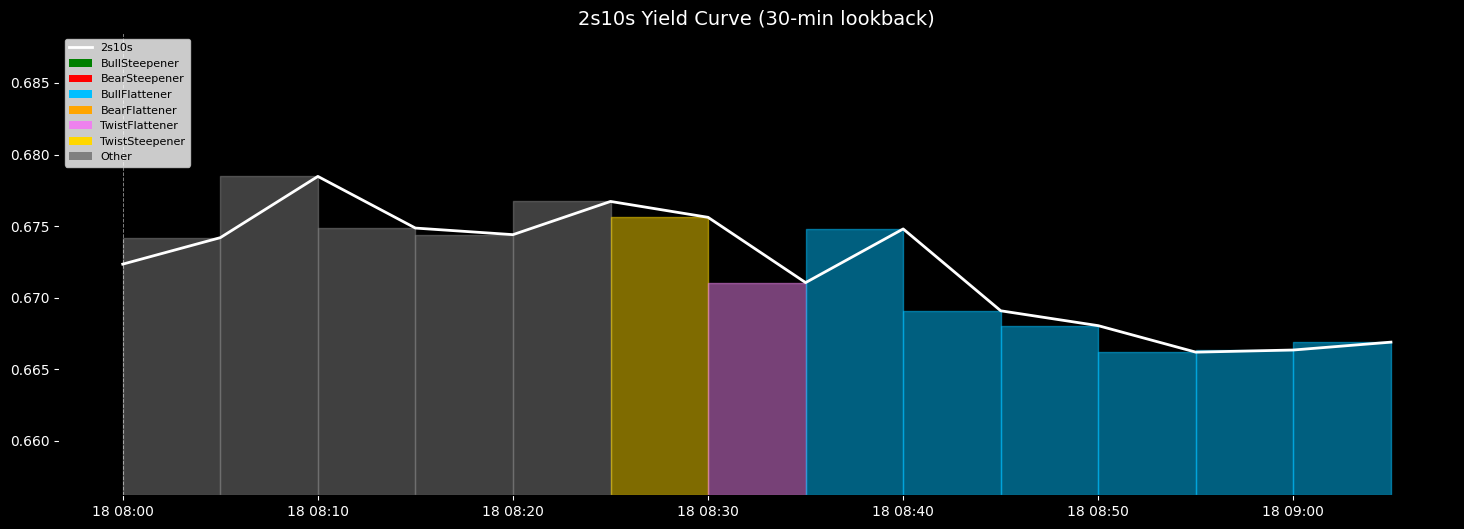

In [7]:
plot_yield_curve_regimes(classify_regime(ESTR_combined))    

In [8]:
#Pull intraday data
print("Fetching 2Y UST data...")
UST_2y = get_intraday_data("USGG2YR Index", start_datetime, end_datetime)
print("Fetching 10Y UST data...")
UST_10y = get_intraday_data("USGG10YR Index", start_datetime, end_datetime)

#Merge dataframes on time
UST_combined = pd.merge(UST_2y[['time', 'close']], UST_10y[['time', 'close']], 
                      on='time', suffixes=('_2y', '_10y'))

#Set time as index
UST_combined['time'] = pd.to_datetime(UST_combined['time'], utc=True)
UST_combined.set_index('time', inplace=True)
UST_combined.index = UST_combined.index.tz_convert('Europe/Zurich')

Fetching 2Y UST data...
Fetching 10Y UST data...


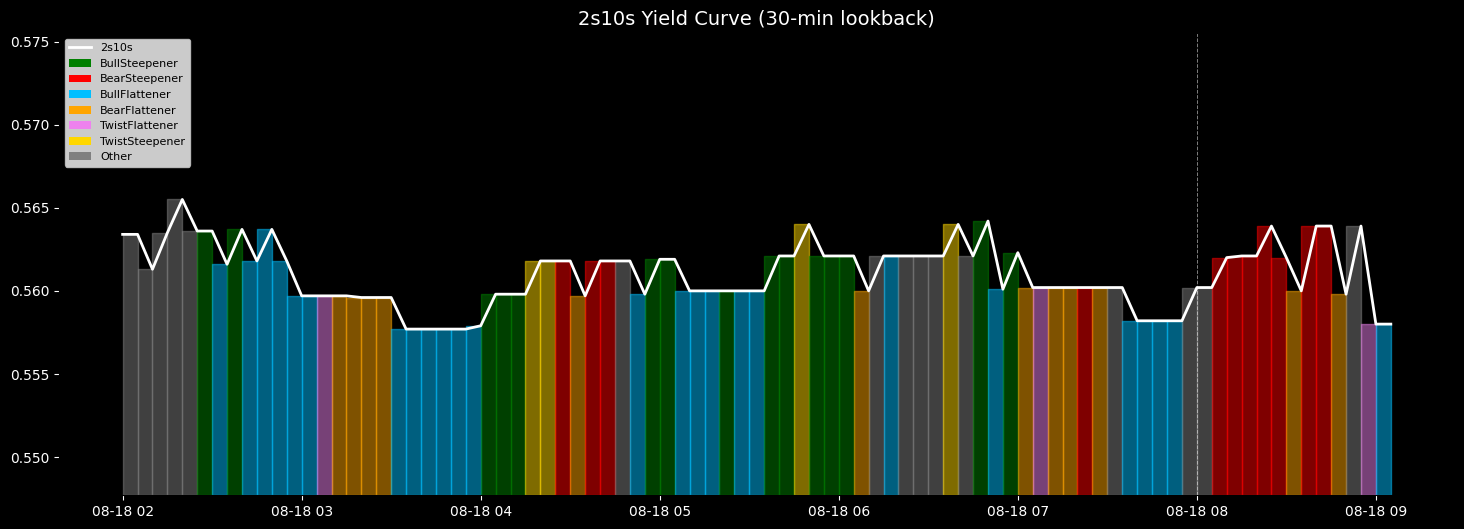

In [9]:
plot_yield_curve_regimes(classify_regime(UST_combined))    

In [10]:
#Pull intraday data
print("Fetching 2Y Bund data...")
Bund_2y = get_intraday_data("GDBR2 Index", start_datetime, end_datetime)
print("Fetching 10Y bund data...")
Bund_10y = get_intraday_data("GDBR10 Index", start_datetime, end_datetime)

#Merge dataframes on time
Bund_combined = pd.merge(Bund_2y[['time', 'close']], Bund_10y[['time', 'close']], 
                      on='time', suffixes=('_2y', '_10y'))

#Set time as index
Bund_combined['time'] = pd.to_datetime(Bund_combined['time'], utc=True)
Bund_combined.set_index('time', inplace=True)
Bund_combined.index = Bund_combined.index.tz_convert('Europe/Zurich')

Fetching 2Y Bund data...
Fetching 10Y bund data...


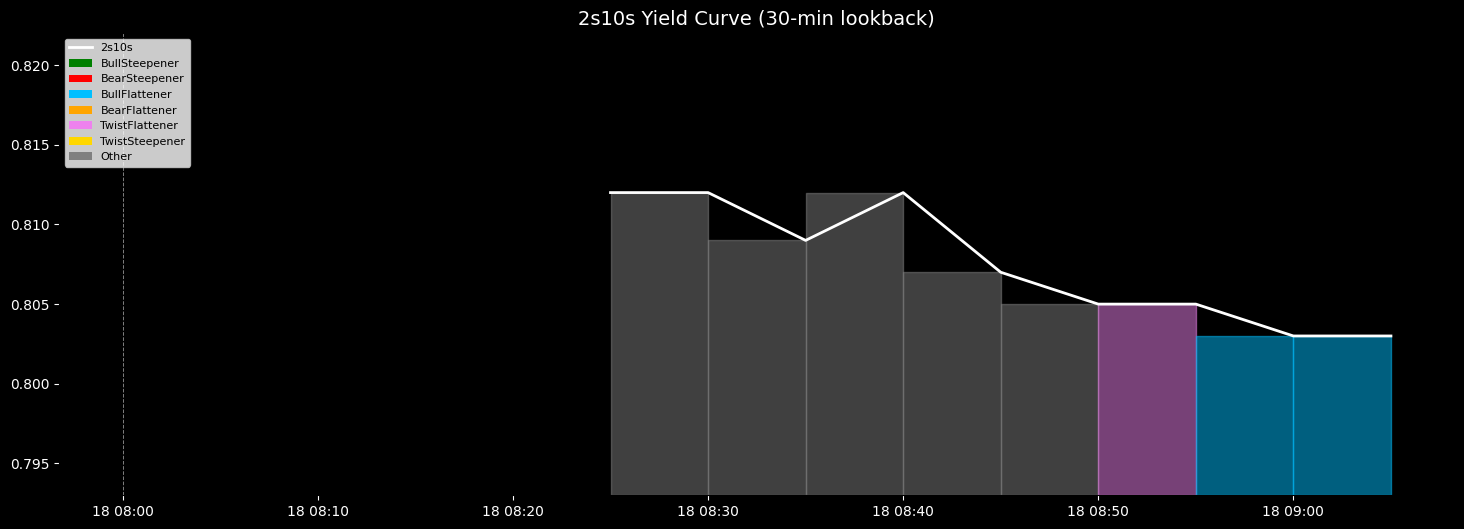

In [11]:
plot_yield_curve_regimes(classify_regime(Bund_combined))    